In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, UtilityFunction, bayesian_optimization
from sklearn.gaussian_process import kernels
from time import time

import lhsmdu

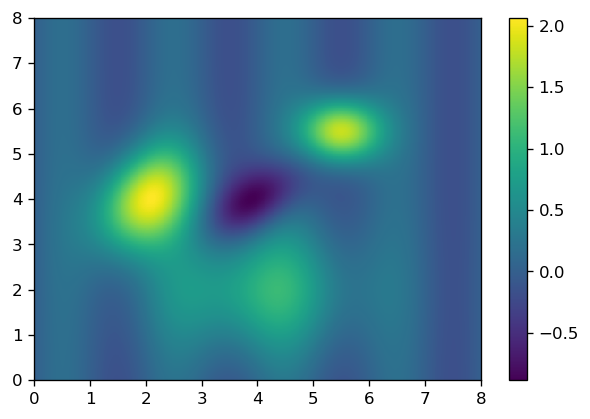

In [2]:
def black_box_function(x, y):
    a = np.exp(-( (x - 2)**2/0.7 + (y - 4)**2/1.2) + (x - 2)*(y - 4)/1.6 )
    b = np.exp(-( (x - 4)**2/3 + (y - 2)**2/2.) )
    c = np.exp(-( (x - 4)**2/0.5 + (y - 4)**2/0.5) + (x - 4)*(y - 4)/0.5 )
    d = np.sin(3.1415 * x)
    e = np.exp(-( (x - 5.5)**2/0.5 + (y - 5.5)**2/.5) )
    return 2*a + b - c + 0.17 * d + 2*e

pbounds = {'x': (0, 8), 'y': (0, 8)}

N = 500
x = np.linspace(pbounds['x'][0], pbounds['x'][1] , N)
y = np.linspace(pbounds['y'][0], pbounds['y'][1] , N)


XX, YY = np.meshgrid(x, y)
Z = black_box_function(XX, YY)
        

plt.figure(dpi=120)
plt.pcolormesh(XX, YY, Z)
plt.colorbar()
plt.show()

In [54]:
class Sampler:
    def __init__(self, bounds, posterior, Ninit):
        
        self.ndim = len(bounds.keys())
        self.bounds = bounds
        
        self.posterior = posterior
        self.optimizer = BayesianOptimization(f=self.posterior, pbounds=self.bounds)
        
        init = self.__get_initials(Ninit)
        self.__feed_initials(init)
    
    def __get_initials(self, Ninit):
        randseed = int(time())
        init = lhsmdu.sample(self.ndim, Ninit, numToAverage=5 ,randomSeed=randseed)
        
        for key, i in zip(self.bounds.keys(), range(self.ndim)):
            bounds = self.bounds[key]
            parameter_range = bounds[1] - bounds[0]
            left_end = bounds[0]
            init[i, :] = left_end + parameter_range*init[i, :]
            
        return np.array(init).T
    
    def __feed_initials(self, init):
        for i in range(init.shape[0]):
            point = list(init[i, :])
            self.optimizer.probe(point, lazy=False)
    
    
    def suggest_point(self, kappa, xi):
        utility = UtilityFunction(kind="ucb", kappa=kappa, xi=xi)
        next_point_to_probe = self.optimizer.suggest(utility)
        return next_point_to_probe
    
    
    def draw_sample(self, kappa, xi=0.0):
        next_point_to_probe = self.suggest_point(kappa, xi)
        target = self.posterior(**next_point_to_probe)
        self.optimizer.register(params=next_point_to_probe, target=target)
        return target
    
    
    def evaluate_point(self, point):
        target = self.posterior(**point)
        self.optimizer.register(params=point, target=target)
        return target
    
    
    def emulate_posterior(self, length_scale):
        data = self.optimizer.res
        npoints = len(data)
        X = np.zeros(shape=(npoints, self.ndim))
        Y = np.zeros(shape=(npoints, 1))

        for i in range(npoints):
            pars, target = data[i]['params'], data[i]['target']
            Y[i, 0] = target
            for key, j in zip(pars.keys(), range(self.ndim)):
                X[i, j] = pars[key]
        
        kernel = kernels.RBF(length_scale)
        gp_regressor = bayesian_optimization.GaussianProcessRegressor(kernel)
    
        gp_regressor = gp_regressor.fit(X, Y)
        return gp_regressor
    
    def evaluate_posterior(self):
        pass
    
    
    def draw_emulated_posterior(self, length_scale, plot=True, log=False):
        if self.ndim != 2:
            print("Only works for 2D")
            return -1
        xlabel, ylabel = list(self.bounds.keys())
        
        N = 500
        X = np.linspace(self.bounds[xlabel][0], self.bounds[xlabel][1], N)
        Y = np.linspace(self.bounds[ylabel][0], self.bounds[ylabel][1], N)
        XX, YY = np.meshgrid(X, Y)
        rXX, rYY = np.ravel(XX), np.ravel(YY)
        points = np.vstack([rXX, rYY]).T
        gp_regressor = self.emulate_posterior(length_scale)
        Z = gp_regressor.predict(points)
        
        Z = Z.reshape(N, N)
        if plot == True:
            plt.figure(dpi=120)
            if log:
                plt.pcolormesh(XX, YY, Z)
            else:
                plt.pcolormesh(XX, YY, np.exp(Z))
            plt.colorbar()
            plt.show()
            plt.close()
        
        return XX, YY, Z

    
    def draw_2d_posterior(self):
        if self.ndim != 2:
            print("Only works for 2D")
            return -1
        N = len(self.optimizer.res)
        x, y, z = np.zeros(N), np.zeros(N), np.zeros(N)
        for i in range(N):
            point = self.optimizer.res[i]
            key1, key2 = list(self.optimizer.res[0]['params'].keys())
            x[i] = point['params'][key1]
            y[i] = point['params'][key2]
            z[i] = point['target']
        
        plt.figure(dpi=120)
        plt.tricontourf(x, y, z)
        plt.colorbar()
        plt.scatter(x[:-1], y[:-1], marker='x', c='red')
        plt.scatter(x[-1], y[-1], marker='o', c='orange')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

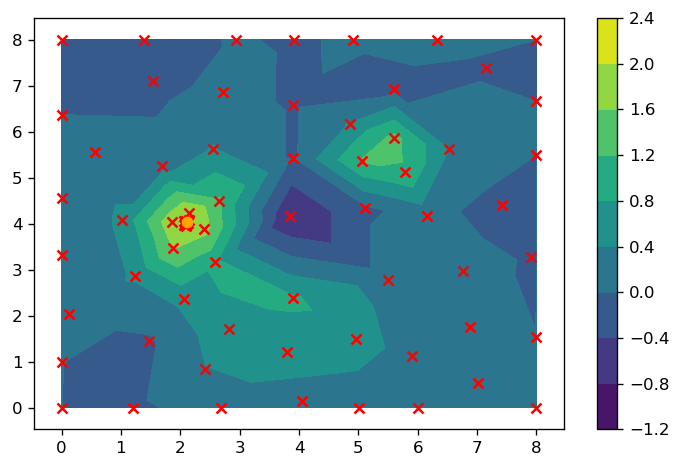

In [80]:
# sampler = Sampler(pbounds, black_box_function, 10)

for i in range(25):
    sampler.draw_sample(kappa=5)
    print(i, end=', ')

sampler.draw_2d_posterior()
    

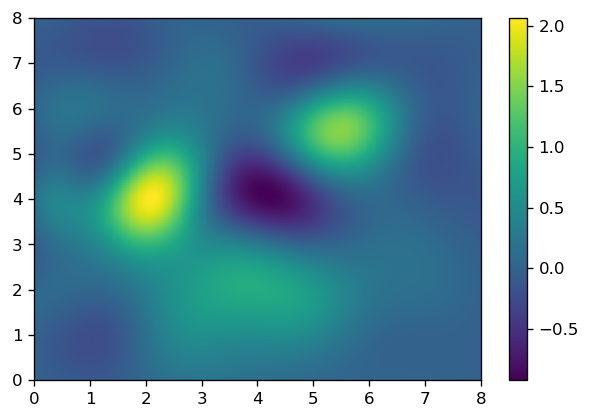

In [85]:
XXX, YYY, ZZ = sampler.draw_emulated_posterior(length_scale=0.5, plot=True, log=True)

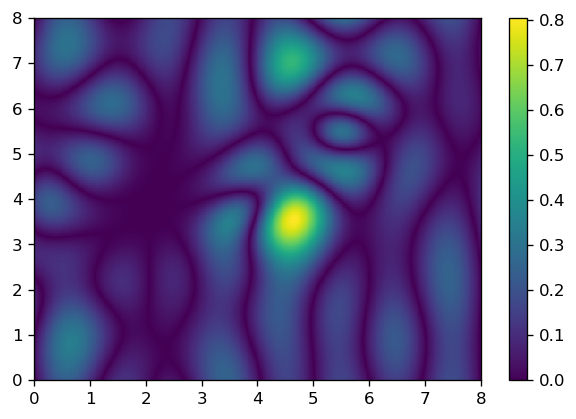

In [86]:
plt.figure(dpi=120)
plt.pcolormesh(XXX, YYY, np.abs(ZZ-Z))
plt.colorbar()
plt.show()